# Coding lecture 4

- Implementing Quasi-Newton method in a minimal function.

### Rosenbrock function

The Rosenbrock function, also referred to as the Valley or Banana function, is a popular test problem for gradient-based optimization algorithms. It will be shown in the plot below in its two-dimensional form.

The function is unimodal, and unique local minimum (which is the global minimum) lies in a narrow, parabolic valley. However, even though this valley is easy to find, convergence to the minimum is difficult (Picheny et al., 2012).

In 2D, common choice is $a=1, b=100$, the unique local minimum is at $(x,y) = (a, a^2)$
$$
f(x,y)=(a-x)^{2}+b(y-x^{2})^{2}
$$

In general in $\mathbb{R}^n$, for $n$ even number,
$$
f(\mathbf {x} )=f(x_{1},x_{2},\dots ,x_{n})=\sum _{i=1}^{n/2}\left[100(x_{2i-1}^{2}-x_{2i})^{2}+(x_{2i-1}-1)^{2}\right].
$$

Reference:
- Picheny, V., Wagner, T., & Ginsbourger, D. (2012). A benchmark of kriging-based infill criteria for noisy optimization.

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
# for plot a surface in 3d space

In [ ]:
import torch
# torch by default is float32 or single precision
# float64 or double precision
torch.set_default_dtype(torch.float64)

In [ ]:
f1 = lambda a: a**2
# a here can be any type of variable
# that supports **2 operand

print(f1(torch.arange(5)))


tensor([ 0,  1,  4,  9, 16])
18


In [ ]:
f2 = lambda s: s[0] + s[1]

print(f2([10, 8]))
print(f2(torch.eye(5)))

18
tensor([1., 1., 0., 0., 0.])


In [ ]:
# a simple version of the Rosenbrock function in 2D
b = 10
f = lambda x: (x[0]-1)**2 + b*(x[1]-x[0]**2)**2


In [ ]:

# Evaluate function
x_grid = torch.linspace(-2, 2, steps=100)
y_grid = torch.linspace(-1, 4, steps=100)
X, Y = torch.meshgrid(x_grid, y_grid, indexing='ij')
# meshgrid is doing tensor product
# produces all possible combination
# of (x_i, y_i) from {x_i}, {y_i}
Z = f([X, Y])

print(x_grid.size())
print(X.size())

torch.Size([100])
torch.Size([100, 100])


In [ ]:
a1, a2 = torch.meshgrid(torch.arange(2),
                       torch.arange(2),
                        indexing='ij')
print(a1)
print(a2)

tensor([[0, 0],
        [1, 1]])
tensor([[0, 1],
        [0, 1]])


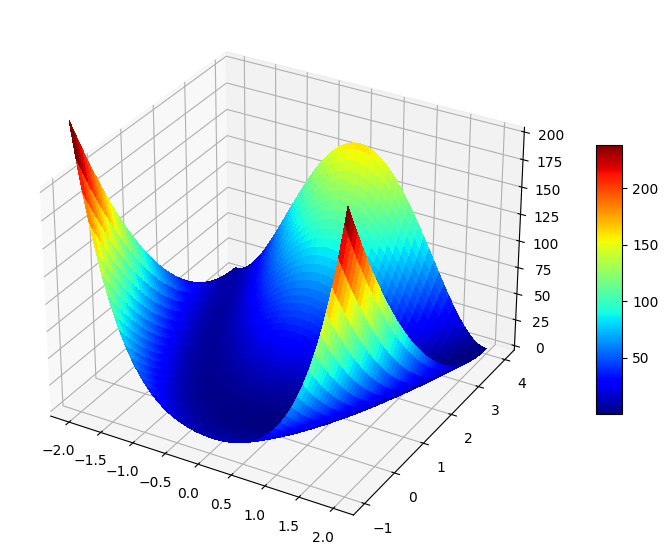

In [ ]:
# Initialize figure
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(projection='3d')


# Plot the surface
surf = ax.plot_surface(X, Y, Z,
                       cmap=cm.jet,
                       linewidth=0,
                       antialiased=False)
ax.set_zlim(0, 200)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

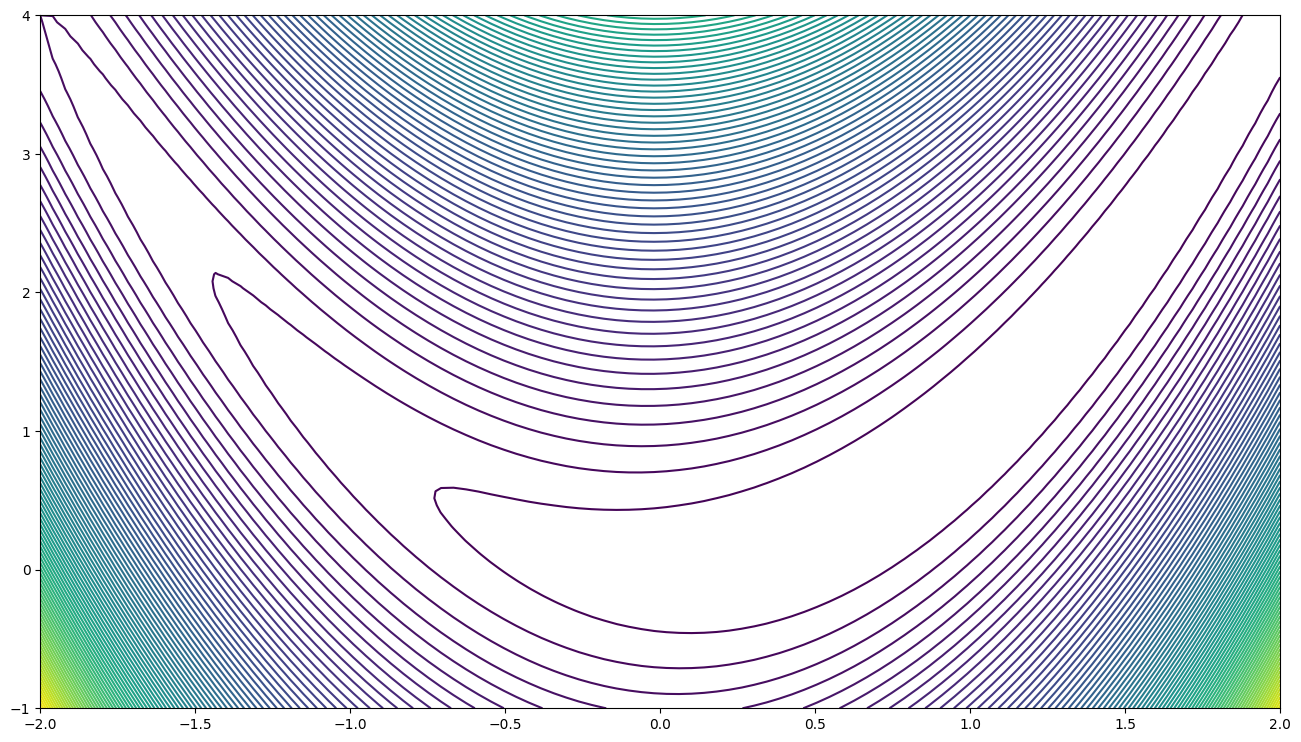

In [ ]:
plt.figure(figsize=(16, 9))
plt.contour(X, Y, Z, levels=100)
plt.show()

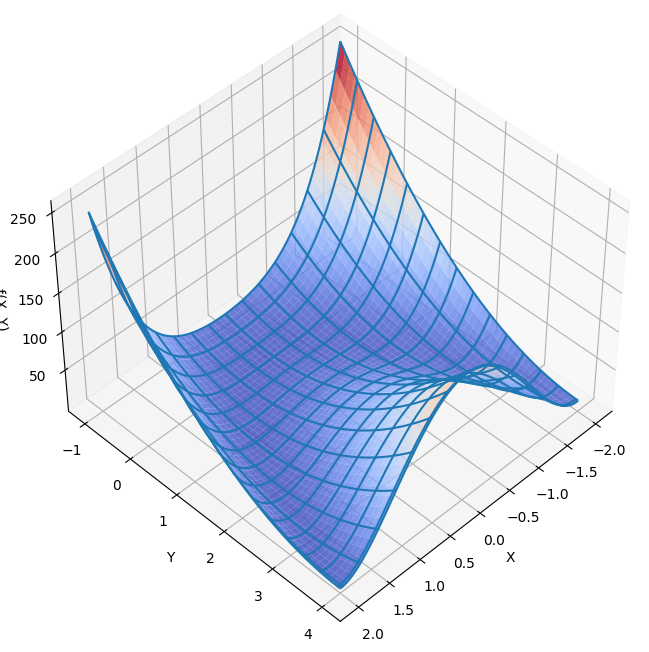

In [ ]:
def plotter(E, A):
  fig = plt.figure(figsize = [12, 8])
  ax = plt.axes(projection='3d')
  ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.8)
  ax.plot_wireframe(X, Y, Z, rcount=15, ccount=15)
  ax.view_init(elev=E, azim=A)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('f(X, Y)')
  # ax.contourf(x_grid, y_grid, Z)
plotter(45, 45)

from ipywidgets import interactive
iplot = interactive(plotter,
                    {'auto_display': False},
                    E = (-90, 90, 5),
                    A = (-90, 90, 5),)

In [ ]:
# iplot

## Quasi-Newton method

**Inputs** $\boldsymbol{x}^{(0)}$, $\boldsymbol{H}_0$ spd, a way to compute (approximate) $\nabla f$

**Output** approximation to $\mathbf{x}^*$

- for $k=0,1,2,\dots$ until converging (or a customized stopping criterion)
	1. Compute $\boldsymbol{g}^{(k)} = \nabla f(\boldsymbol{x}^{(k)})$.
	2. Compute $\boldsymbol{d}^{(k)} = -\boldsymbol{H}_k \boldsymbol{g}^{(k)} $ .
	3. Find $\alpha_k = \arg \min_{\alpha\geq 0} f\left(\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d}^{(k)}\right)$, or do an inexact line search.
	4. Update $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha_k \boldsymbol{d}^{(k)}$
	5. Update $\boldsymbol{H}_{k+1}$

In [ ]:
def f(x, n=2, b=100):
    '''
    Rosenbrock function in n-dimensions
    '''
    if isinstance(x, torch.Tensor):
        n = x.size(-1)
    elif isinstance(x, list):
        n = len(x)
    return sum(b*(x[i+1]-x[i]**2)**2 + (x[i]-1)**2 for i in range(n-1))

def grad(f, x, h=1e-8):
    '''
    central finite difference to approximate gradient
    '''
    n = x.size(-1)
    nabla = torch.zeros((n,))
    for i in range(n):
        x_for = x.clone()
        x_back = x.clone()
        x_for[i] = x_for[i] + h
        x_back[i] = x_back[i] - h
        nabla[i] = (f(x_for) - f(x_back))/(2*h)
    return nabla


## Inexact line search
Choose a relative big step size first, then there are two conditions (Wolfe conditions) to check for $\alpha_k$, for $0<c_1<c_2<1$. Nocedal and Wright suggested $c_1 = 10^{-4}, c_2 = 0.9$ for quasi-Newton.

- The function value is non-increasing
$$f(\mathbf{x}^{(k)}+\alpha_{k}\mathbf{d}^{(k)})\leq f(\mathbf{x}^{(k)})+c_{1}\alpha _{k}(\mathbf{d}^{(k)})^{\top }\nabla f(\mathbf{x}^{(k)})$$

- Curvature condition, preventing the steps being too small.
$$-(\mathbf{d}^{(k)})^{\top }\nabla f(\mathbf{x} _{k}+\alpha^{(k)}\mathbf{d}^{(k)})\leq -c_{2}(\mathbf{d}^{(k)})^{\mathrm {T} }\nabla f(\mathbf{x}^{(k)})$$

In [ ]:
# @ is torch.matmul
a2 = torch.randn(3,3)
a3 = torch.randn(3,5)
a4 = torch.matmul(a2, a3)
a4_compare = a2@a3

print(a4 == a4_compare)
print(torch.all(a4 == a4_compare))
# bad coding practice
# == not recommended for float or double

print(torch.allclose(a4, a4_compare))

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]])
tensor(True)
True


In [ ]:

def line_search(f, x, d, g, h=1e-8):
    '''
    backtrack inexact line search with Wolfe condition
    '''
    alpha = 1
    c1 = 1e-4
    c2 = 0.9
    fx = f(x)
    x_new = x + alpha * d
    g_new = grad(f, x_new, h=h)
    while f(x_new) >= fx + (c1*alpha*g.T@d) or g_new.T@d <= c2*g.T@d :
        alpha *= 0.5
        x_new = x + alpha * d
        g_new = grad(f, x_new, h=h)
    return alpha

In [ ]:
x0 = torch.tensor([-1.2, 1])
n = x0.size(-1) # dimension of problem
g = grad(f, x0) # initial gradient
H = torch.eye(n) # initial approx to inverse of Hessian
x = x0.clone()
it = 1
max_it = 100

while torch.linalg.norm(g) > 1e-5: # while gradient is big do BFGS
    if it > max_it:
        print('Maximum iterations reached!')
        break
    print('\nIteration:', it)
    print('x:        ', x.numpy())
    print('Gradient: ', g.numpy())
    print('Hessian:  ', H[0].numpy())
    print('          ', H[1].numpy())
    it += 1
    d = -H@g # search direction
    alpha = line_search(f, x, d, g) # line search
    s = alpha * d
    x_new = x + alpha * d
    g_new = grad(f,x_new)
    y = g_new - g
    y = y.reshape(n,1)
    s = s.reshape(n,1)
    r = 1/(y.T@s)
    li = (torch.eye(n)-(r*((s@(y.T)))))
    ri = (torch.eye(n)-(r*((y@(s.T)))))
    hess_inter = li@H@ri
    H = hess_inter + (r*((s@(s.T)))) # BFGS Update
    g = g_new
    x = x_new


Iteration: 1
x:         [-1.2  1. ]
Gradient:  [-215.59999901  -88.        ]
Hessian:   [1. 0.]
           [0. 1.]

Iteration: 2
x:         [-0.98945313  1.0859375 ]
Gradient:  [38.33802973 21.38400217]
Hessian:   [ 0.15726986 -0.36318155]
           [-0.36318155  0.84392179]

Iteration: 3
x:         [-0.77234582  0.57059243]
Gradient:  [-11.55411449  -5.18512728]
Hessian:   [ 0.0404049  -0.08404469]
           [-0.08404469  0.1772175 ]

Iteration: 4
x:         [-0.74128543  0.51842579]
Gradient:  [-12.6977284  -6.2156607]
Hessian:   [ 0.08025271 -0.11919895]
           [-0.11919895  0.18289967]

Iteration: 5
x:         [-0.46315858  0.14171217]
Gradient:  [-16.41417988 -14.56073937]
Hessian:   [ 0.04540479 -0.05354911]
           [-0.05354911  0.06898992]

Iteration: 6
x:         [-0.49759089  0.26729165]
Gradient:  [0.92483055 3.93899124]
Hessian:   [ 0.03913537 -0.03854115]
           [-0.03854115  0.04291115]

Iteration: 7
x:         [-0.38197123  0.13390901]
Gradient:  [-4.596336

<ipython-input-23-78b8f8cba4fd>:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  while f(x_new) >= fx + (c1*alpha*g.T@d) or g_new.T@d <= c2*g.T@d :



Iteration: 30
x:         [0.99929802 0.99787352]
Gradient:  [ 0.28759578 -0.14460138]
Hessian:   [0.43193413 0.85417021]
           [0.85417021 1.69344   ]

Iteration: 31
x:         [0.99858978 0.99709153]
Gradient:  [ 0.03313132 -0.01800127]
Hessian:   [0.4129421  0.82441355]
           [0.82441355 1.65088294]

Iteration: 32
x:         [0.99974895 0.99949561]
Gradient:  [ 0.00043706 -0.0004697 ]
Hessian:   [0.48719789 0.97468434]
           [0.97468434 1.95479695]

Iteration: 33
x:         [0.99999382 0.99998778]
Gradient:  [-6.75675706e-05  2.76064503e-05]
Hessian:   [0.49972959 0.99948815]
           [0.99948815 2.00387903]


In [ ]:
from tqdm.auto import tqdm
from time import sleep

In [ ]:
x = torch.tensor([-1.2, 1])
n = x0.size(-1) # dimension of problem
g = grad(f, x) # initial gradient
it = 1
max_it = 1000

with tqdm(total=max_it) as pbar:
    for it in range(max_it):
        g = grad(f, x)
        if it > max_it:
            print('Maximum iterations reached!')
            break

        it += 1
        d = -g
        alpha = line_search(f, x, d, g) # line search
        x = x + alpha * d
        if it % 10 == 0:
            sleep(0.2)
            pbar.update(10)
            desc = f'f(x) = {f(x):.7e}'
            desc += f' | x = {x[0].numpy():.7f}, {x[1].numpy():.7f}'
            desc += f' | g = {g[0].numpy():.7f}, {g[1].numpy():.7f}'
            pbar.set_description(desc)

  0%|          | 0/1000 [00:00<?, ?it/s]